In [4]:
from pathlib import Path

import transformers
import matplotlib.pyplot as plt
import numpy as np
import albumentations as A
from albumentations.pytorch import ToTensorV2
import cv2

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import torch.nn as nn

from data.image_dataset import ImageDataset
from engine.training_engine import TrainingEngine
import models

In [5]:
data_root = Path('~/tmp/image_data')

# test baseline resnet18 without data augmentations

In [8]:
# init model and get its preferred image transforms

# model_state_path = '~/tmp/saved_models/baseline_resnet18_no_aug/2025_Jan_29_14_29/checkpoint_epoch_020.pth'
model_state_path = '../../../saved_models/baseline_resnet18_no_aug/2025_Jan_29_14_29/checkpoint_epoch_020.pth'

model, model_transforms = models.resnet.build_resnet18(n_categories=1)

state_dict = torch.load(model_state_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [9]:
# init dataset and loader
test_set = ImageDataset(
    data_root / 'test.csv',
    transform=model_transforms
)

test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

In [10]:
# TODO: don't make the engine require an optimizer, etc.

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = transformers.get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=1, 
    num_training_steps=1
)
criterion = nn.BCEWithLogitsLoss()

engine = TrainingEngine(
    model=model,
    train_loader=None,
    loss_func=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    val_loader=None,
    test_loader=test_loader,
    use_cuda=False,
    ckpt_freq=None
)

In [11]:
results = engine.evaluate(mode='evaluation')

Evaluating: 100%|███████████████████████████████████████████████████| 32/32 [01:48<00:00,  3.38s/it]


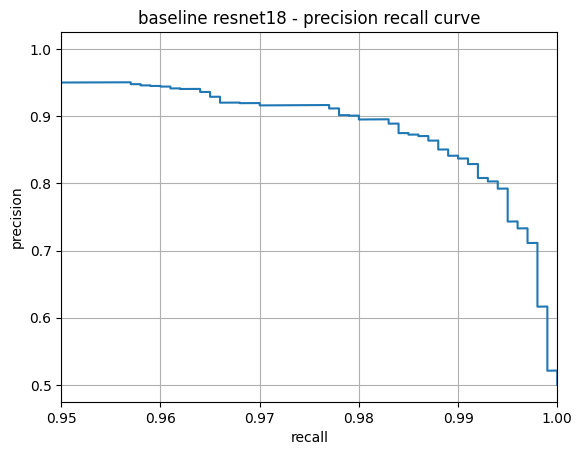

In [12]:
precision, recall, thresholds = results[('PRC', 'vector')]
plt.figure()
plt.title('baseline resnet18 - precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim(0.95, 1.0)
plt.grid(which='both')
# plt.xscale('log')
plt.plot(recall.cpu().numpy(), precision.cpu().numpy())

In [13]:
for (name, met_type), value in results.items():
    if met_type == 'scalar':
        print(f'{name}:\t{value:.2%}')

op_point = np.argmin(recall.cpu().numpy() > 0.999)
prec_at_999_rec = precision.cpu().numpy()[op_point]
thr_at_999_rec = thresholds.cpu().numpy()[op_point]
print(f'{prec_at_999_rec:.2%} precision at 99.9% recall, threshold {thr_at_999_rec:.8f}')

val_loss_mean:	53.23%
accuracy:	95.10%
precision:	95.74%
recall:	94.40%
F1:	95.07%
AUPRC:	98.68%
52.11% precision at 99.9% recall, threshold 0.00000015


# test resnet18 with data augmentations

In [14]:
model_state_path = '../../../saved_models/baseline_resnet18_with_albumentations/2025_Jan_29_14_37/checkpoint_epoch_020.pth'
model, model_transforms = models.resnet.build_resnet18(n_categories=1)

state_dict = torch.load(model_state_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [15]:
# test with Albumentations transforms to approximate training transforms

In [16]:
transforms_eval = A.Compose(
    [
        A.SmallestMaxSize(max_size=256),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [17]:
# init dataset and loader
test_set_alb = ImageDataset(
    data_root / 'test.csv',
    transform=transforms_eval
)
test_loader_alb = DataLoader(test_set_alb, batch_size=64, shuffle=False)

In [18]:
# TODO: don't make the engine require an optimizer, etc.

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = transformers.get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=1, 
    num_training_steps=1
)
criterion = nn.BCEWithLogitsLoss()

engine = TrainingEngine(
    model=model,
    train_loader=None,
    loss_func=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    val_loader=None,
    test_loader=test_loader_alb,
    use_cuda=False,
    ckpt_freq=None
)

In [19]:
results = engine.evaluate(mode='evaluation')

Evaluating: 100%|███████████████████████████████████████████████████| 32/32 [01:37<00:00,  3.05s/it]


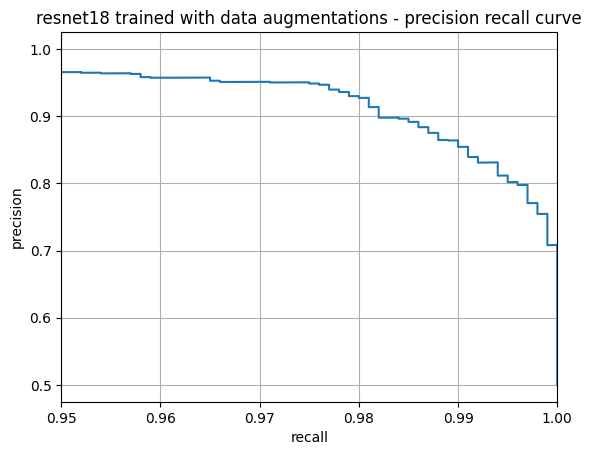

In [20]:
precision_aug, recall_aug, thresholds_aug = results[('PRC', 'vector')]
plt.figure()
plt.title('resnet18 trained with data augmentations - precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim(0.95, 1.0)
plt.grid(which='both')
# plt.xscale('log')
plt.plot(recall_aug.cpu().numpy(), precision_aug.cpu().numpy())

In [21]:
for (name, met_type), value in results.items():
    if met_type == 'scalar':
        print(f'{name}:\t{value:.2%}')
        
op_point = np.argmin(recall_aug.cpu().numpy() > 0.999)
prec_at_999_rec = precision_aug.cpu().numpy()[op_point]
thr_at_999_rec = thresholds_aug.cpu().numpy()[op_point]
print(f'{prec_at_999_rec:.2%} precision at 99.9% recall, threshold {thr_at_999_rec:.6f}')

val_loss_mean:	53.11%
accuracy:	96.10%
precision:	95.73%
recall:	96.50%
F1:	96.12%
AUPRC:	99.17%
70.80% precision at 99.9% recall, threshold 0.000412


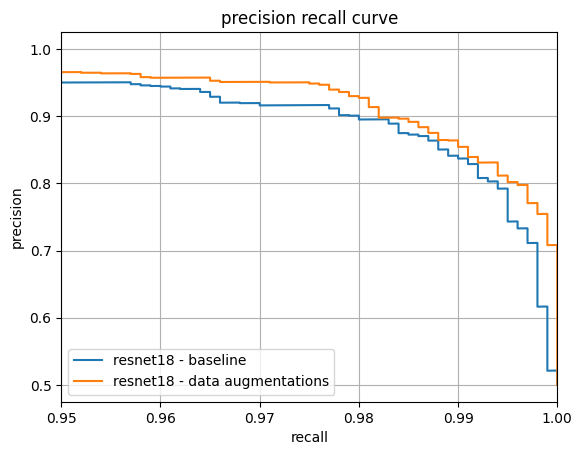

In [22]:
plt.figure()
plt.title('precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim(0.95, 1.0)
plt.grid(which='both')
# plt.xscale('log')
plt.plot(recall.cpu().numpy(), precision.cpu().numpy(), label='resnet18 - baseline')
plt.plot(recall_aug.cpu().numpy(), precision_aug.cpu().numpy(), label='resnet18 - data augmentations')
plt.legend()

## test resnext-50

In [23]:
model_state_path = '../../../saved_models/resnext50_albumentations/2025_Jan_29_15_37/checkpoint_epoch_020.pth'
model, model_transforms = models.resnext.build_resnext50(n_categories=1)

state_dict = torch.load(model_state_path, map_location='cpu', weights_only=True)
model.load_state_dict(state_dict)

transforms_eval = A.Compose(
    [
        A.SmallestMaxSize(max_size=232),
        A.CenterCrop(height=224, width=224),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

# init dataset and loader
test_set_alb = ImageDataset(
    data_root / 'test.csv',
    transform=transforms_eval
)
test_loader_alb = DataLoader(test_set_alb, batch_size=64, shuffle=False)

optimizer = optim.Adam(model.parameters(), lr=1e-4)
scheduler = transformers.get_scheduler(
    'cosine', 
    optimizer, 
    num_warmup_steps=1, 
    num_training_steps=1
)
criterion = nn.BCEWithLogitsLoss()

engine = TrainingEngine(
    model=model,
    train_loader=None,
    loss_func=criterion,
    optimizer=optimizer,
    scheduler=scheduler,
    val_loader=None,
    test_loader=test_loader_alb,
    use_cuda=False,
    ckpt_freq=None
)

results = engine.evaluate(mode='evaluation')

Evaluating: 100%|███████████████████████████████████████████████████| 32/32 [05:03<00:00,  9.50s/it]


In [24]:
precision_resnext, recall_resnext, thresholds_resnext = results[('PRC', 'vector')]

for (name, met_type), value in results.items():
    if met_type == 'scalar':
        print(f'{name}:\t{value:.2%}')
        
op_point = np.argmin(recall_resnext.cpu().numpy() > 0.999)
prec_at_999_rec = precision_resnext.cpu().numpy()[op_point]
thr_at_999_rec = thresholds_resnext.cpu().numpy()[op_point]
print(f'{prec_at_999_rec:.2%} precision at 99.9% recall, threshold {thr_at_999_rec:.6f}')

val_loss_mean:	53.23%
accuracy:	95.70%
precision:	94.37%
recall:	97.20%
F1:	95.76%
AUPRC:	99.03%
59.96% precision at 99.9% recall, threshold 0.000030


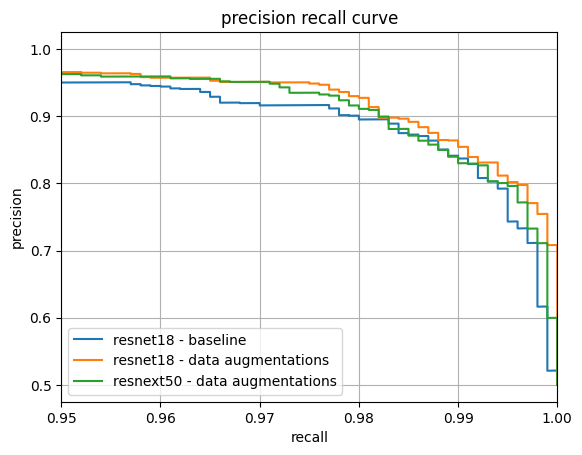

In [25]:
plt.figure()
plt.title('precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.xlim(0.95, 1.0)
plt.grid(which='both')
# plt.xscale('log')
plt.plot(recall.cpu().numpy(), precision.cpu().numpy(), label='resnet18 - baseline')
plt.plot(recall_aug.cpu().numpy(), precision_aug.cpu().numpy(), label='resnet18 - data augmentations')
plt.plot(recall_resnext.cpu().numpy(), precision_resnext.cpu().numpy(), label='resnext50 - data augmentations')
plt.legend()

In [29]:
recall_dermfound_lrc = np.load('lrc_recall.npy')
prec_dermfound_lrc = np.load('lrc_precision.npy')

In [ ]:
plt.figure()
plt.title('precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid(which='both')
# plt.xscale('log')
plt.plot(recall.cpu().numpy(), precision.cpu().numpy(), label='resnet18 - baseline')
plt.plot(recall_aug.cpu().numpy(), precision_aug.cpu().numpy(), label='resnet18 - data augmentations')
plt.plot(recall_resnext.cpu().numpy(), precision_resnext.cpu().numpy(), label='resnext50 - baseline')
plt.legend()

In [30]:
recall_dermfound_lrc.shape

(2001,)

In [31]:
recall.shape

torch.Size([1707])

In [34]:
recall_dermfound_lrc_interp = np.interp(
    np.linspace(0, recall_dermfound_lrc.shape[0], recall.shape[0]),
    np.arange(recall_dermfound_lrc.shape[0]),
    recall_dermfound_lrc
)
prec_dermfound_lrc_interp = np.interp(
    np.linspace(0, prec_dermfound_lrc.shape[0], precision.shape[0]),
    np.arange(prec_dermfound_lrc.shape[0]),
    prec_dermfound_lrc
)

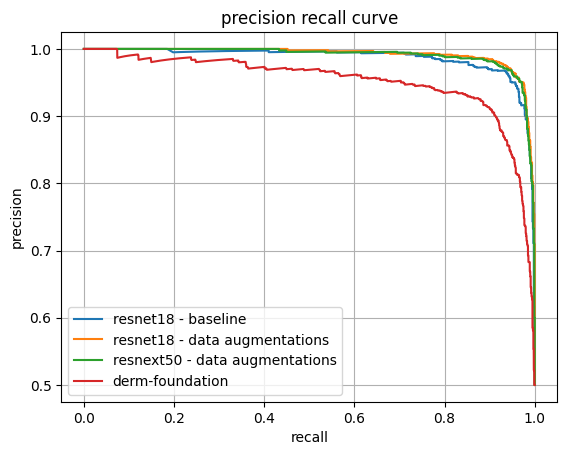

In [36]:
plt.figure()
plt.title('precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid(which='both')
# plt.xscale('log')
plt.plot(recall.cpu().numpy(), precision.cpu().numpy(), label='resnet18 - baseline')
plt.plot(recall_aug.cpu().numpy(), precision_aug.cpu().numpy(), label='resnet18 - data augmentations')
plt.plot(recall_resnext.cpu().numpy(), precision_resnext.cpu().numpy(), label='resnext50 - data augmentations')
plt.plot(recall_dermfound_lrc_interp, prec_dermfound_lrc_interp, label='derm-foundation')
plt.legend()

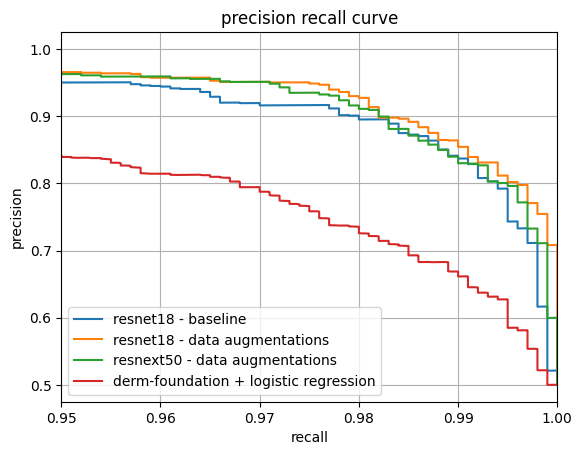

In [39]:
plt.figure()
plt.xlim(0.95, 1.0)
plt.title('precision recall curve')
plt.xlabel('recall')
plt.ylabel('precision')
plt.grid(which='both')
plt.plot(recall.cpu().numpy(), precision.cpu().numpy(), label='resnet18 - baseline')
plt.plot(recall_aug.cpu().numpy(), precision_aug.cpu().numpy(), label='resnet18 - data augmentations')
plt.plot(recall_resnext.cpu().numpy(), precision_resnext.cpu().numpy(), label='resnext50 - data augmentations')
plt.plot(recall_dermfound_lrc_interp, prec_dermfound_lrc_interp, label='derm-foundation + logistic regression')
plt.legend()